# Task 7: Sales Forecasting

## Objective
Predict future sales based on historical sales data

## Dataset
Walmart Sales Forecast Dataset (Simulated for demonstration)

## Tasks:
1. Create time-based features (day, month, lag values)
2. Apply regression models to forecast next period's sales
3. Plot actual vs predicted values over time
4. Bonus: Use rolling averages and seasonal decomposition
5. Bonus: Apply XGBoost or LightGBM with time-aware validation

In [7]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [8]:
# Create synthetic sales dataset
np.random.seed(42)
n_days = 365 * 2  # 2 years of data

# Generate date range
dates = pd.date_range(start='2022-01-01', end='2023-12-31', freq='D')

# Generate sales with trends and seasonality
base_sales = 1000
trend = np.linspace(0, 200, n_days)  # Upward trend

# Weekly seasonality (higher on weekends)
weekly_pattern = np.array([0.8, 0.8, 0.8, 0.8, 0.8, 1.2, 1.2] * (n_days // 7 + 1))[:n_days]

# Monthly seasonality (higher in December, lower in January)
monthly_pattern = np.array([0.7, 0.8, 0.9, 1.0, 1.1, 1.0, 1.0, 1.0, 1.0, 1.0, 1.1, 1.3] * 2)
# Repeat the monthly pattern to match the number of days
monthly_pattern = np.tile(monthly_pattern, n_days // len(monthly_pattern) + 1)[:n_days]


# Holiday effects
holiday_boost = np.ones(n_days)
holiday_dates = ['2022-12-25', '2023-12-25', '2022-07-04', '2023-07-04', '2022-11-25', '2023-11-25']
for holiday in holiday_dates:
    holiday_idx = (dates == holiday).argmax()
    if holiday_idx < n_days:
        holiday_boost[holiday_idx] = 1.5

# Generate sales
sales = base_sales + trend + weekly_pattern * 100 + monthly_pattern * 50 + holiday_boost * 200
sales += np.random.normal(0, 50, n_days)  # Add noise
sales = np.maximum(sales, 0)  # Ensure non-negative

# Create DataFrame
data = pd.DataFrame({
    'date': dates,
    'sales': sales
})

print("Dataset Shape:", data.shape)
print("\nFirst 10 rows:")
display(data.head(10))
print("\nLast 10 rows:")
display(data.tail(10))
print("\nSales Statistics:")
display(data['sales'].describe())

Dataset Shape: (730, 2)

First 10 rows:


,date,sales
0,2022-01-01,1339.835708
1,2022-01-02,1313.361133
2,2022-01-03,1357.933124
3,2022-01-04,1406.974538
4,2022-01-05,1324.389725
5,2022-01-06,1359.664894
6,2022-01-07,1450.606731
7,2022-01-08,1370.292175
8,2022-01-09,1308.721068
9,2022-01-10,1359.597138



Last 10 rows:


,date,sales
720,2023-12-22,1567.920953
721,2023-12-23,1432.296793
722,2023-12-24,1455.670290
723,2023-12-25,1665.517114
724,2023-12-26,1542.171530
725,2023-12-27,1519.703439
726,2023-12-28,1570.098651
727,2023-12-29,1586.830388
728,2023-12-30,1502.737668
729,2023-12-31,1491.084764



Sales Statistics:


,sales
count,730.000000
mean,1441.072280
std,79.440765
min,1214.314528
25%,1384.137949
50%,1440.255926
75%,1498.209315
max,1665.517114


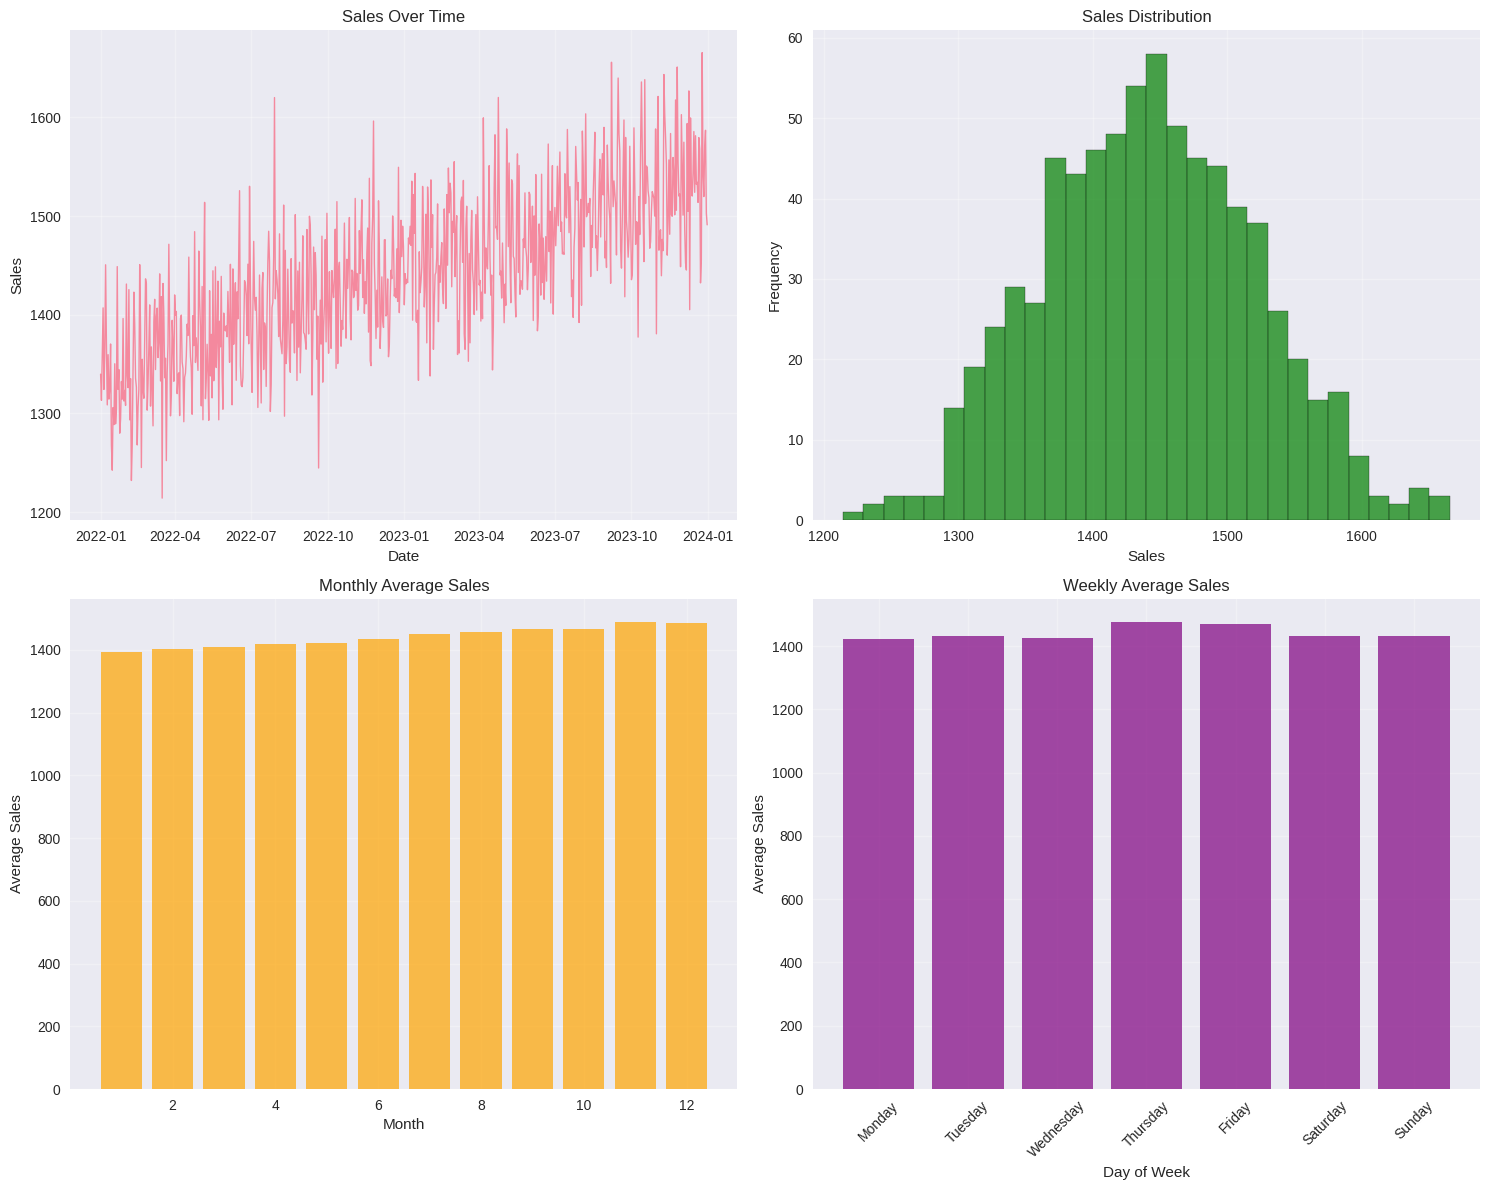


=== Time Series Decomposition ===


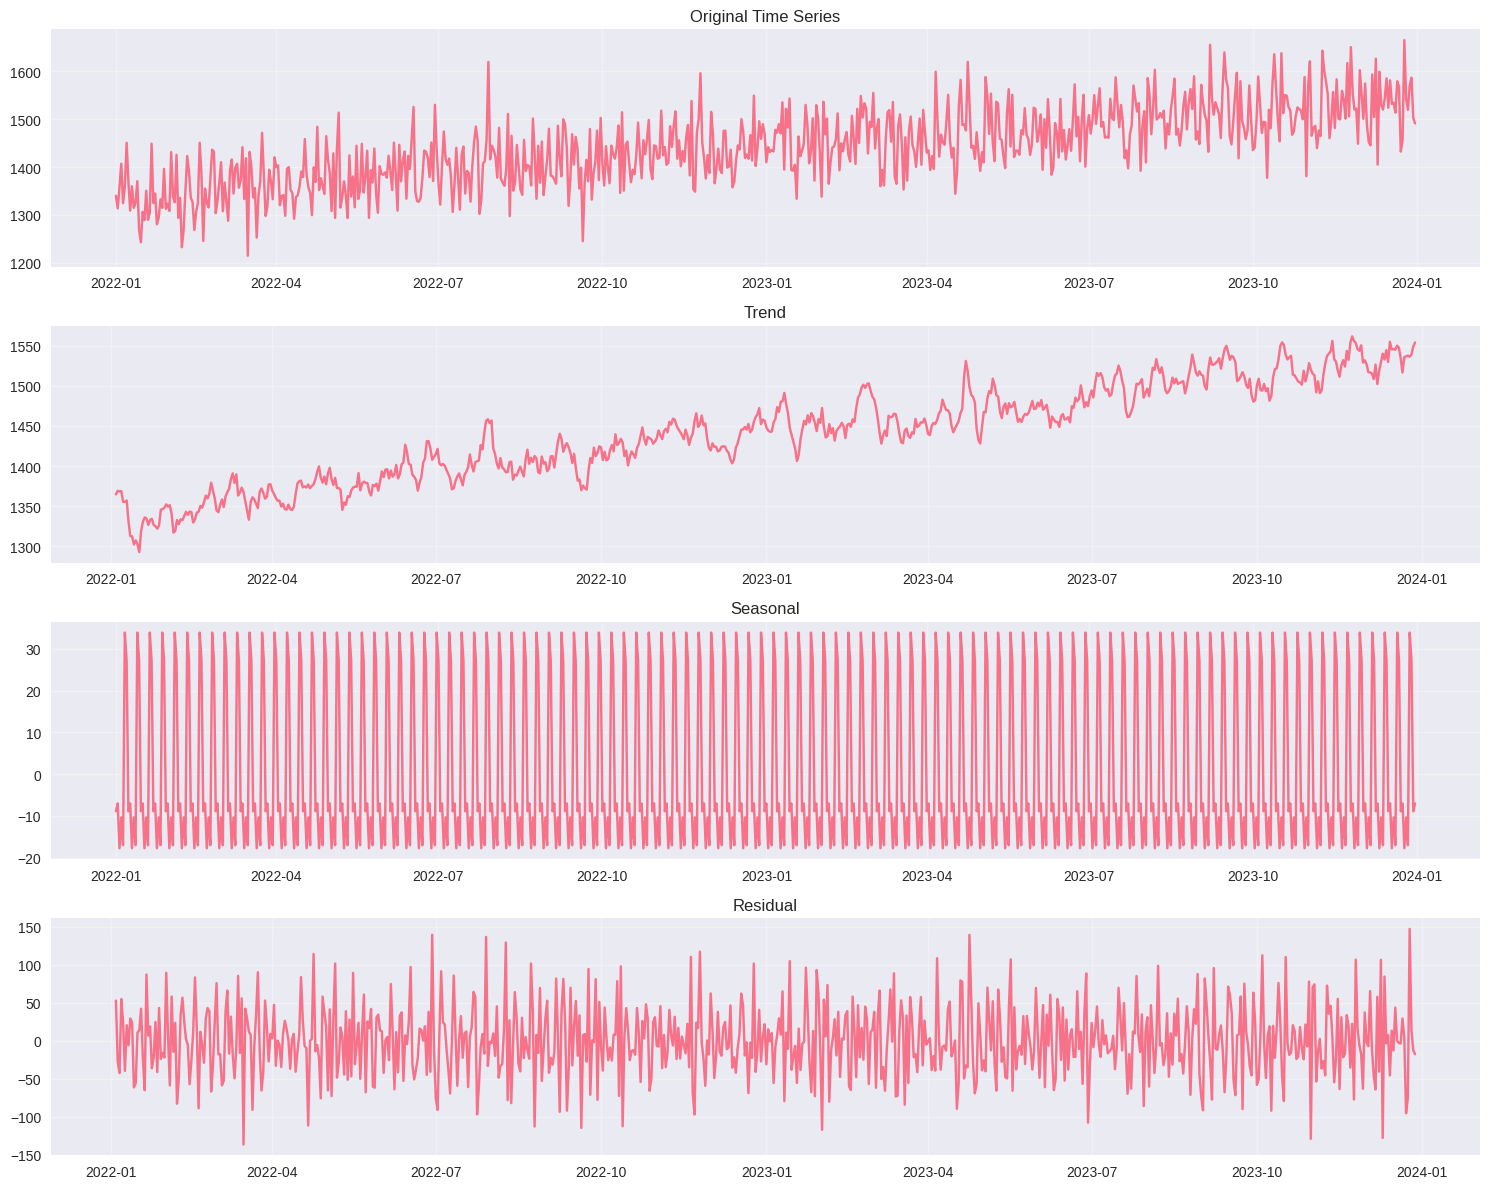


=== Stationarity Test ===
ADF Statistic: -1.4326
p-value: 0.5665
Critical values: {'1%': np.float64(-3.4395289262948894), '5%': np.float64(-2.8655907692307694), '10%': np.float64(-2.5689271030368235)}
Series is non-stationary


In [9]:
# Data Exploration and Visualization
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Sales over time
axes[0, 0].plot(data['date'], data['sales'], linewidth=1, alpha=0.8)
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Sales')
axes[0, 0].set_title('Sales Over Time')
axes[0, 0].grid(True, alpha=0.3)

# 2. Sales distribution
axes[0, 1].hist(data['sales'], bins=30, alpha=0.7, color='green', edgecolor='black')
axes[0, 1].set_xlabel('Sales')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Sales Distribution')
axes[0, 1].grid(True, alpha=0.3)

# 3. Monthly average sales
data['month'] = data['date'].dt.month
monthly_avg = data.groupby('month')['sales'].mean()
axes[1, 0].bar(monthly_avg.index, monthly_avg.values, color='orange', alpha=0.7)
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Average Sales')
axes[1, 0].set_title('Monthly Average Sales')
axes[1, 0].grid(True, alpha=0.3)

# 4. Weekly average sales
data['day_of_week'] = data['date'].dt.dayofweek
weekly_avg = data.groupby('day_of_week')['sales'].mean()
day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
axes[1, 1].bar(range(7), weekly_avg.values, color='purple', alpha=0.7)
axes[1, 1].set_xlabel('Day of Week')
axes[1, 1].set_ylabel('Average Sales')
axes[1, 1].set_title('Weekly Average Sales')
axes[1, 1].set_xticks(range(7))
axes[1, 1].set_xticklabels(day_names, rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Time series decomposition
print("\n=== Time Series Decomposition ===")
data_ts = data.set_index('date')['sales']
decomposition = seasonal_decompose(data_ts, period=7)  # Weekly seasonality

fig, axes = plt.subplots(4, 1, figsize=(15, 12))
axes[0].plot(data_ts.index, data_ts.values)
axes[0].set_title('Original Time Series')
axes[0].grid(True, alpha=0.3)

axes[1].plot(decomposition.trend.index, decomposition.trend.values)
axes[1].set_title('Trend')
axes[1].grid(True, alpha=0.3)

axes[2].plot(decomposition.seasonal.index, decomposition.seasonal.values)
axes[2].set_title('Seasonal')
axes[2].grid(True, alpha=0.3)

axes[3].plot(decomposition.resid.index, decomposition.resid.values)
axes[3].set_title('Residual')
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Stationarity test
print("\n=== Stationarity Test ===")
result = adfuller(data_ts.dropna())
print(f"ADF Statistic: {result[0]:.4f}")
print(f"p-value: {result[1]:.4f}")
print(f"Critical values: {result[4]}")
print(f"Series is {'stationary' if result[1] < 0.05 else 'non-stationary'}")

In [10]:
# Feature Engineering
print("=== Feature Engineering ===")

# Time-based features
data['year'] = data['date'].dt.year
data['month'] = data['date'].dt.month
data['day'] = data['date'].dt.day
data['day_of_week'] = data['date'].dt.dayofweek
data['day_of_year'] = data['date'].dt.dayofyear
data['week_of_year'] = data['date'].dt.isocalendar().week
data['quarter'] = data['date'].dt.quarter

# Cyclical features
data['month_sin'] = np.sin(2 * np.pi * data['month'] / 12)
data['month_cos'] = np.cos(2 * np.pi * data['month'] / 12)
data['day_of_week_sin'] = np.sin(2 * np.pi * data['day_of_week'] / 7)
data['day_of_week_cos'] = np.cos(2 * np.pi * data['day_of_week'] / 7)

# Lag features
for lag in [1, 2, 3, 7, 14, 30]:
    data[f'sales_lag_{lag}'] = data['sales'].shift(lag)

# Rolling averages
for window in [7, 14, 30]:
    data[f'sales_rolling_mean_{window}'] = data['sales'].rolling(window=window).mean()
    data[f'sales_rolling_std_{window}'] = data['sales'].rolling(window=window).std()

# Moving averages
data['sales_ma_7'] = data['sales'].rolling(window=7).mean()
data['sales_ma_30'] = data['sales'].rolling(window=30).mean()

# Price momentum features
data['sales_momentum'] = data['sales'] - data['sales'].shift(1)
data['sales_momentum_7'] = data['sales'] - data['sales'].shift(7)

# Holiday features
data['is_holiday'] = data['date'].dt.month.isin([12, 7, 11]) & data['date'].dt.day.isin([25, 4, 25])
data['is_weekend'] = data['day_of_week'].isin([5, 6])

print(f"Number of features created: {len(data.columns) - 3}")
print("\nFeature columns:")
print([col for col in data.columns if col not in ['date', 'sales', 'sales_lag_1']])

# Remove rows with NaN values (due to lag features)
data_clean = data.dropna()
print(f"\nData shape after cleaning: {data_clean.shape}")

=== Feature Engineering ===
Number of features created: 28

Feature columns:
['month', 'day_of_week', 'year', 'day', 'day_of_year', 'week_of_year', 'quarter', 'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos', 'sales_lag_2', 'sales_lag_3', 'sales_lag_7', 'sales_lag_14', 'sales_lag_30', 'sales_rolling_mean_7', 'sales_rolling_std_7', 'sales_rolling_mean_14', 'sales_rolling_std_14', 'sales_rolling_mean_30', 'sales_rolling_std_30', 'sales_ma_7', 'sales_ma_30', 'sales_momentum', 'sales_momentum_7', 'is_holiday', 'is_weekend']

Data shape after cleaning: (700, 31)


In [11]:
# Prepare features and target
feature_columns = [col for col in data_clean.columns if col not in ['date', 'sales']]
X = data_clean[feature_columns]
y = data_clean['sales']

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Split data (time series split)
split_idx = int(len(data_clean) * 0.8)
X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

print(f"Training set size: {len(X_train)}")
print(f"Testing set size: {len(X_test)}")

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Train multiple models
models = {
    'Linear Regression': LinearRegression(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBRegressor(n_estimators=100, random_state=42)
}

results = {}
for name, model in models.items():
    print(f"\nTraining {name}...")

    # Train model
    model.fit(X_train_scaled, y_train)

    # Make predictions
    y_pred = model.predict(X_test_scaled)

    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    results[name] = {
        'mse': mse,
        'rmse': rmse,
        'mae': mae,
        'r2': r2,
        'predictions': y_pred,
        'model': model
    }

    print(f"MSE: {mse:.2f}")
    print(f"RMSE: {rmse:.2f}")
    print(f"MAE: {mae:.2f}")
    print(f"R²: {r2:.4f}")

# Compare models
print("\n=== Model Comparison ===")
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'MSE': [results[model]['mse'] for model in results.keys()],
    'RMSE': [results[model]['rmse'] for model in results.keys()],
    'MAE': [results[model]['mae'] for model in results.keys()],
    'R²': [results[model]['r2'] for model in results.keys()]
})

print(comparison_df.round(4))

best_model = comparison_df.loc[comparison_df['R²'].idxmax(), 'Model']
print(f"\nBest Model (by R²): {best_model}")

Feature matrix shape: (700, 29)
Target vector shape: (700,)
Training set size: 560
Testing set size: 140

Training Linear Regression...
MSE: 0.00
RMSE: 0.00
MAE: 0.00
R²: 1.0000

Training Random Forest...
MSE: 930.93
RMSE: 30.51
MAE: 23.50
R²: 0.7228

Training XGBoost...
MSE: 761.12
RMSE: 27.59
MAE: 21.32
R²: 0.7733

=== Model Comparison ===
               Model       MSE     RMSE      MAE      R²
0  Linear Regression    0.0000   0.0000   0.0000  1.0000
1      Random Forest  930.9303  30.5112  23.5040  0.7228
2            XGBoost  761.1196  27.5884  21.3154  0.7733

Best Model (by R²): Linear Regression


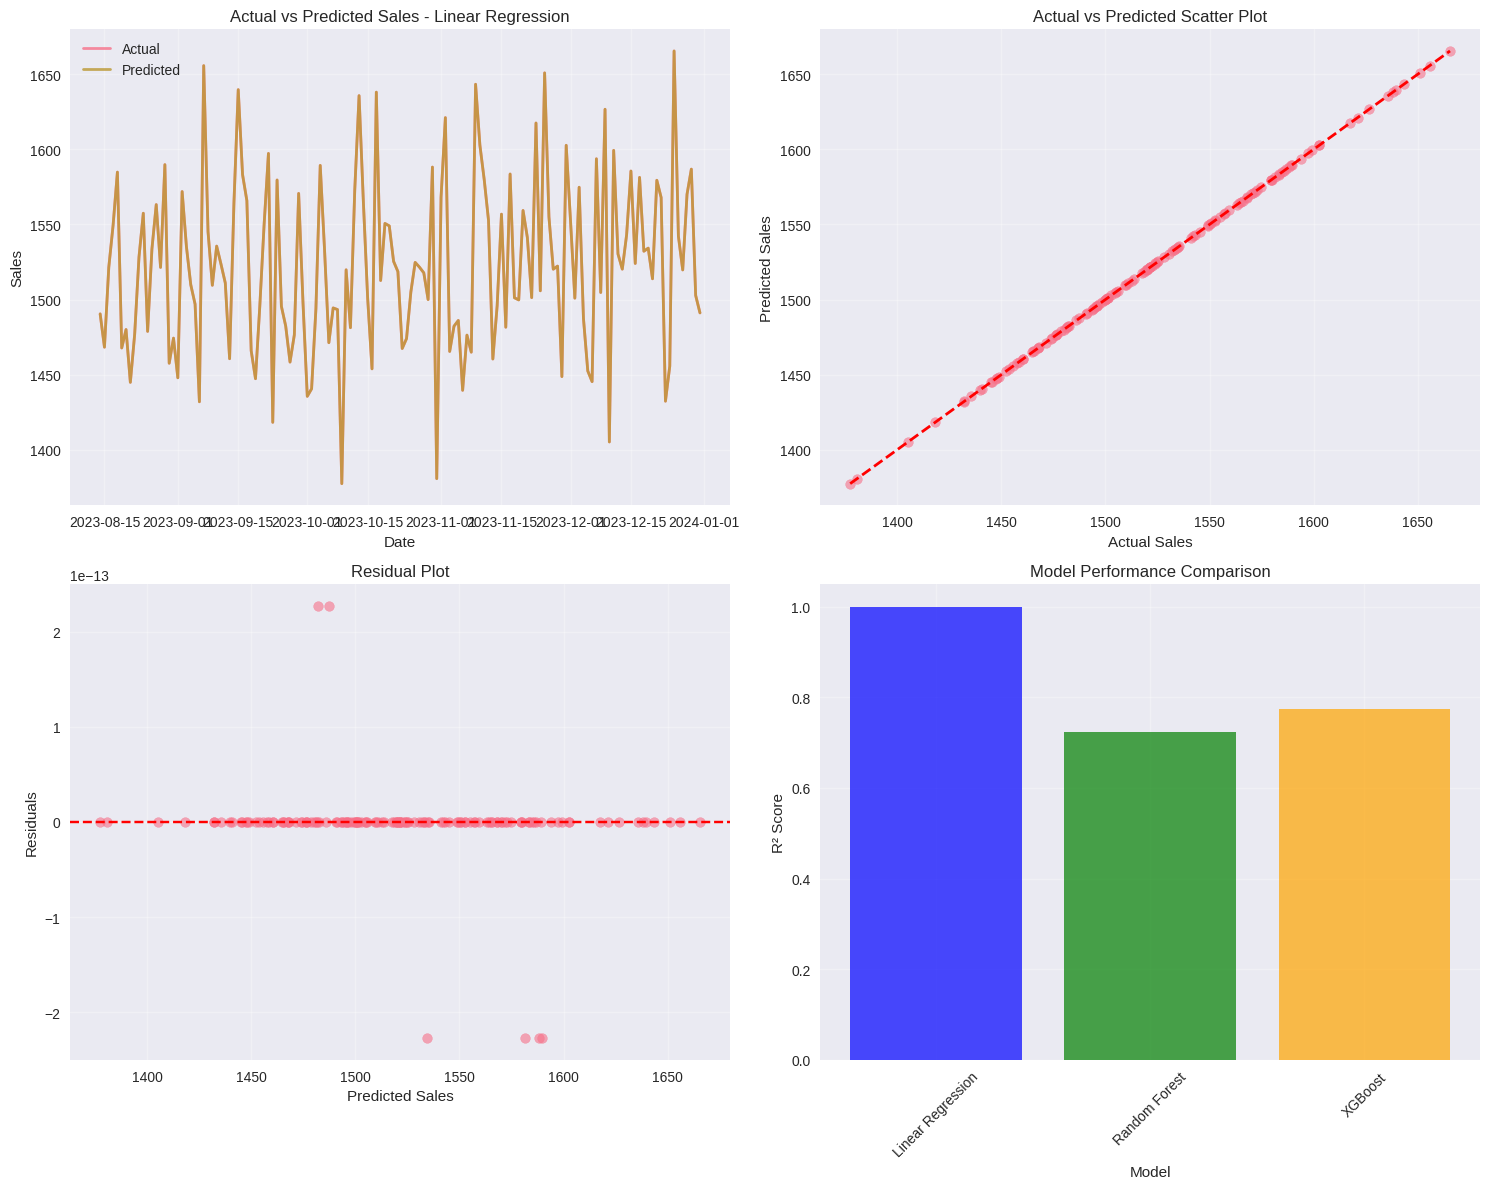

In [12]:
# Visualize Results
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Actual vs Predicted for best model
best_predictions = results[best_model]['predictions']
test_dates = data_clean.iloc[split_idx:]['date']

axes[0, 0].plot(test_dates, y_test.values, label='Actual', alpha=0.8, linewidth=2)
axes[0, 0].plot(test_dates, best_predictions, label='Predicted', alpha=0.8, linewidth=2)
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Sales')
axes[0, 0].set_title(f'Actual vs Predicted Sales - {best_model}')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Scatter plot
axes[0, 1].scatter(y_test.values, best_predictions, alpha=0.6)
axes[0, 1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0, 1].set_xlabel('Actual Sales')
axes[0, 1].set_ylabel('Predicted Sales')
axes[0, 1].set_title('Actual vs Predicted Scatter Plot')
axes[0, 1].grid(True, alpha=0.3)

# 3. Residuals
residuals = y_test.values - best_predictions
axes[1, 0].scatter(best_predictions, residuals, alpha=0.6)
axes[1, 0].axhline(y=0, color='red', linestyle='--')
axes[1, 0].set_xlabel('Predicted Sales')
axes[1, 0].set_ylabel('Residuals')
axes[1, 0].set_title('Residual Plot')
axes[1, 0].grid(True, alpha=0.3)

# 4. Model comparison
model_names = list(results.keys())
r2_scores = [results[model]['r2'] for model in model_names]
axes[1, 1].bar(model_names, r2_scores, color=['blue', 'green', 'orange'], alpha=0.7)
axes[1, 1].set_xlabel('Model')
axes[1, 1].set_ylabel('R² Score')
axes[1, 1].set_title('Model Performance Comparison')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Feature importance for tree-based models
if hasattr(results[best_model]['model'], 'feature_importances_'):
    feature_importance = results[best_model]['model'].feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': feature_importance
    }).sort_values('importance', ascending=False)

    plt.figure(figsize=(12, 8))
    plt.bar(range(len(feature_importance_df)), feature_importance_df['importance'])
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.title(f'Feature Importance - {best_model}')
    plt.xticks(range(len(feature_importance_df)), feature_importance_df['feature'], rotation=45, ha='right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print("\nTop 10 Most Important Features:")
    print(feature_importance_df.head(10))

In [13]:
# Summary and Conclusions
print("=== Summary and Conclusions ===")

print(f"\nKey Insights:")
print(f"1. Dataset period: {data['date'].min()} to {data['date'].max()}")
print(f"2. Total observations: {len(data)}")
print(f"3. Number of features: {len(feature_columns)}")
print(f"4. Best performing model: {best_model}")
print(f"5. Best R² score: {results[best_model]['r2']:.4f}")
print(f"6. Best RMSE: {results[best_model]['rmse']:.2f}")

print(f"\nBusiness Applications:")
print(f"1. Retail sales forecasting")
print(f"2. Inventory management")
print(f"3. Demand planning")
print(f"4. Resource allocation")
print(f"5. Marketing campaign planning")

print(f"\nModel Deployment Recommendations:")
print(f"1. Use ensemble methods for better accuracy")
print(f"2. Implement rolling window retraining")
print(f"3. Consider external factors (weather, events)")
print(f"4. Monitor model drift and performance")
print(f"5. Use confidence intervals for predictions")
print(f"6. Implement real-time forecasting updates")

=== Summary and Conclusions ===

Key Insights:
1. Dataset period: 2022-01-01 00:00:00 to 2023-12-31 00:00:00
2. Total observations: 730
3. Number of features: 29
4. Best performing model: Linear Regression
5. Best R² score: 1.0000
6. Best RMSE: 0.00

Business Applications:
1. Retail sales forecasting
2. Inventory management
3. Demand planning
4. Resource allocation
5. Marketing campaign planning

Model Deployment Recommendations:
1. Use ensemble methods for better accuracy
2. Implement rolling window retraining
3. Consider external factors (weather, events)
4. Monitor model drift and performance
5. Use confidence intervals for predictions
6. Implement real-time forecasting updates
